### 1. Setup 

#### 1.1. Install Dependencies

In [1]:
!pip install tensorflow opencv-python matplotlib

  Using cached opencv_python-4.6.0.66-cp36-abi3-win_amd64.whl (35.6 MB)


In [1]:
%config Completer.use_jedi = False

#### 1.2. Import Dependencies

In [2]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

#### 1.3. Set GPU Growth

#### 1.4. Create Folder Structures

In [4]:
# Setup Paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
POS_PATH

'data\\positive'

In [6]:
# Make the Directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

### 2. Collect Positives and Anchors

#### 2.1. Untar Labelled Faces in the Wild Dataset

In [10]:
# http://vis-www.cs.umass.edu/lfw/

In [12]:
# Uncompress Tar GZ labelled Faces in the Wild Dataset
!tar xzf lfw.tgz

In [14]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

#### 2.2. Collect Positive and Anchor Classes

In [5]:
# Import UUID library to generate unique image names
import uuid

In [6]:
uuid.uuid1()

UUID('1249f7b4-0777-11ed-b100-4cebbd9382b8')

In [30]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    # Cut down frame to 250x250px
    frame = frame[120:120+250, 200:200+250, :]
    
    # Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor path
        cv2.imwrite(imgname, frame)
        
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor path
        cv2.imwrite(imgname, frame)        
    
    # Show image back to the screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()

# Close the image show frame
cv2.destroyAllWindows()

In [19]:
frame[:250, :250, :250].shape

(250, 250, 3)

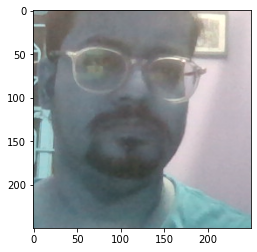

In [22]:
plt.imshow(frame[120:120+250, 200:200+250, :])

### 3. Load and Preprocess Images

#### 3.1. Get Image Directories

In [7]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH + '\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '\*.jpg').take(300)

In [8]:
dir_test = anchor.as_numpy_iterator()

In [9]:
print(dir_test.next())

b'data\\anchor\\e61fc541-045c-11ed-a37d-4cebbd9382b8.jpg'


#### 3.2. Preprocessing - Scale and Resize

In [10]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0
    
    # Return the image 
    return img

In [11]:
img = preprocess('data\\anchor\\f5595b88-045c-11ed-ad46-4cebbd9382b8.jpg')

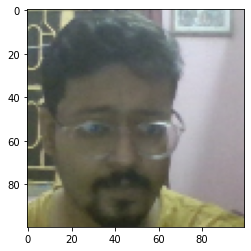

In [12]:
plt.imshow(img)

In [13]:
img.numpy().min()

0.08602941

In [14]:
img.numpy().max()

0.9372549

#### 3.3. Create Labelled Dataset 

In [15]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [16]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [17]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [18]:
samples = data.as_numpy_iterator()

In [19]:
example = samples.next()

In [20]:
example

(b'data\\anchor\\ec531c21-045c-11ed-aa92-4cebbd9382b8.jpg',
 b'data\\positive\\330061e5-0463-11ed-b4c7-4cebbd9382b8.jpg',
 1.0)

#### 3.4. Build Train and Test Partition

In [21]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [22]:
res = preprocess_twin(*example)

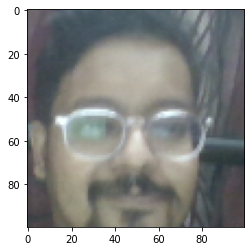

In [23]:
plt.imshow(res[1])

In [38]:
res[2]

1.0

In [24]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [25]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [26]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

### 4. Model Engineering

#### 4.1. Build Embedding Layer

In [27]:
inp = Input(shape=(100,100,3), name='input_image')

In [28]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [29]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [30]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [31]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [32]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [33]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [34]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [37]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [38]:
embedding = make_embedding()

In [39]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

#### 4.2. Build Distance Layer

In [40]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [41]:
l1 = L1Dist()

In [42]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

#### 4.3. Make Siamese Model

In [43]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [44]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [45]:
inp_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [46]:
val_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [47]:
embedding(input_image)

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [48]:
siamese_layer = L1Dist()

In [49]:
distances = siamese_layer(inp_embedding, val_embedding)

In [50]:
classifier = Dense(1, activation='sigmoid')(distances)

In [51]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [52]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [53]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [54]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [55]:
siamese_model = make_siamese_model()

In [56]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

### 5. Training

#### 5.1. Setup Loss and Optimizer 

In [57]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [58]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

#### 5.2. Establish Checkpoints

In [59]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

#### 5.3. Build Train Step Function

In [60]:
test_batch = train_data.as_numpy_iterator()

In [61]:
batch_1 = test_batch.next()

In [62]:
X = batch_1[:2]

In [63]:
y = batch_1[2]

In [64]:
y

array([1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0.],
      dtype=float32)

In [65]:
tf.losses.BinaryCrossentropy??

In [66]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

#### 5.4. Build Training Loop

In [67]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

#### 5.5. Train the model

In [68]:
EPOCHS = 50

In [69]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 590s 22s/step

 Epoch 2/50
27/27 [==============================] - 555s 21s/step

 Epoch 3/50
27/27 [==============================] - 585s 22s/step

 Epoch 4/50
27/27 [==============================] - 553s 20s/step

 Epoch 5/50
27/27 [==============================] - 545s 20s/step

 Epoch 6/50
27/27 [==============================] - 535s 20s/step

 Epoch 7/50
27/27 [==============================] - 546s 20s/step

 Epoch 8/50
27/27 [==============================] - 549s 20s/step

 Epoch 9/50
27/27 [==============================] - 537s 20s/step

 Epoch 10/50
27/27 [==============================] - 541s 20s/step

 Epoch 11/50
27/27 [==============================] - 545s 20s/step

 Epoch 12/50
27/27 [==============================] - 581s 22s/step

 Epoch 13/50
27/27 [======

### 6. Evaluate the Model

#### 6.1. Import Metrics

In [70]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

#### 6.2. Make Predictions

In [71]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [72]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[9.9999964e-01],
       [1.1522315e-08],
       [1.0000000e+00],
       [1.5832084e-08],
       [1.3873015e-05],
       [1.0000000e+00],
       [9.9999988e-01],
       [1.9341902e-08],
       [1.1119074e-08],
       [9.9999619e-01],
       [4.7877233e-08],
       [1.0000000e+00],
       [9.8336466e-07],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9998629e-01]], dtype=float32)

In [73]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1]

In [74]:
y_true

array([1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1.],
      dtype=float32)

#### 6.3. Calculate Metrics

In [75]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [76]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

#### 6.4. Viz Results

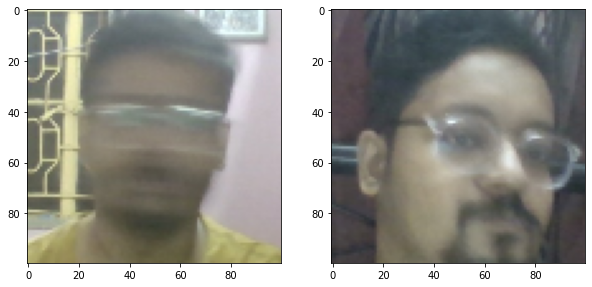

In [79]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[2])

# Renders cleanly
plt.show()

### 7. Save the Model

### 8. Real Time Test